<a href="https://colab.research.google.com/github/JN-Nataraj/ML-Linear_Regression-Kaggle_HousePrice_Prediction/blob/main/Notebook/Kaggle_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop('Id', axis=1)
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Mean =  180921.19589041095
Median =  163000.0


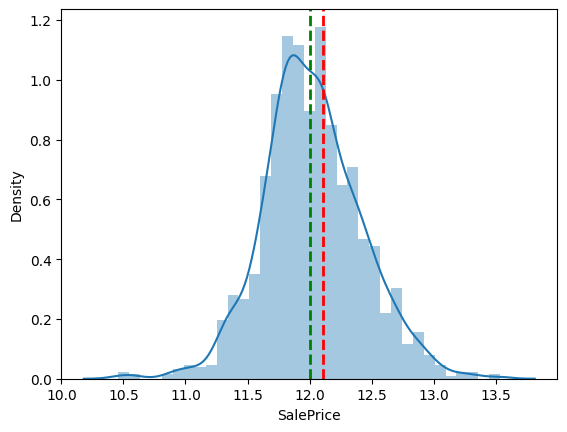

In [ ]:
# Check How House Price Value is Distributed
sns.distplot(np.log1p(train['SalePrice']))
#plot mean and median in distplot
plt.axvline(np.log1p(train['SalePrice'].mean()), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.log1p(train['SalePrice'].median()), color='green', linestyle='dashed', linewidth=2)

print("Mean = ",train['SalePrice'].mean())
print("Median = ",train['SalePrice'].median())

#Converting the house price to logarthimic
train['SalePrice_log'] = np.log1p(train['SalePrice'])

In [75]:
#Check if there are any null values in features our training dataset
#train.info()
null_cols = train.columns[train.isnull().any()]
null_info = pd.DataFrame (
    {
        "Null Count" : train[null_cols].isnull().sum(),
        "Data Type"  : train[null_cols].dtypes
    }
)
null_info.sort_values(by='Null Count', ascending=False)

,Null Count,Data Type
GarageYrBlt,81,float64
BsmtFinType2,38,object
BsmtExposure,38,object
BsmtCond,37,object
BsmtQual,37,object
BsmtFinType1,37,object
Electrical,1,object


In [ ]:
# Fixing Pool qualty Data by updating NA as No Pool
train['PoolQC'] = train['PoolQC'].fillna('No Pool')
# Fixing MiscFeature Data by updating NA as None
train['MiscFeature'] = train['MiscFeature'].fillna('None')
# Fixing Alley Data by updating NA as No Alley Access
train['Alley'] = train['Alley'].fillna('No Alley Access')
# Fixing Fence Data by updating NA as No Fence
train['Fence'] = train['Fence'].fillna('No Fence')
# Fixing MasVnrType Data by updating NA & None  as No Veneer
train['MasVnrType'] = train['MasVnrType'].fillna('No Veneer')
# Fixing FireplaceQu Data by updating NA as No Veneer
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
# Fixing GarageCond Data by updating NA as No Garage
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
# Fixing GarageQual Data by updating NA as No Garage
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
# Fixing GarageFinish Data by updating NA as No Garage
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
# Fixing GarageType Data by updating NA as No Garage
train['GarageType'] = train['GarageType'].fillna('No Garage')


Mean =  70.40534979423869
Median =  70.0


,Condition1,Condition2,Neighborhood,LotFrontage


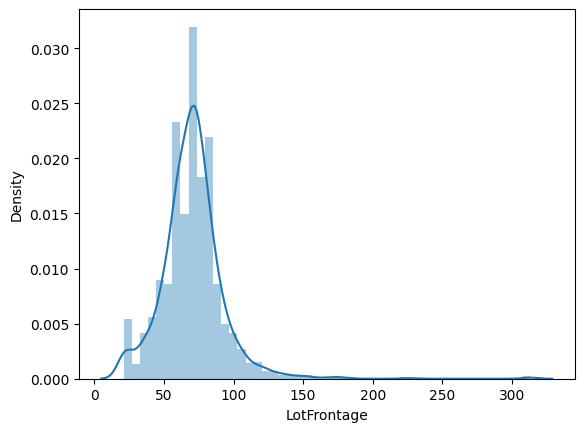

In [ ]:
#Fixing of LotFrontage requires additional analysis
#LotFrontage distribution
sns.distplot(train['LotFrontage'])
print("Mean = ",train['LotFrontage'].mean())#70
print("Median = ",train['LotFrontage'].median())#69

# Fixing LotFrontage Data by grouping condition 1, condition 2 and neighbour
train['LotFrontage'] = train.groupby(['Condition1','Condition2','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train['LotFrontage'] = train.groupby(['Condition1','Condition2'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train['LotFrontage'] = train.groupby(['Condition1'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train[train['LotFrontage'].isnull()][['Condition1','Condition2','Neighborhood','LotFrontage']]


In [ ]:
#Introducing a new feature HasGarage to see in future if Grage is impacting the price
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x != 0 else 1)


In [74]:
# Fixing MasVnrArea Data as we have some data where we have MasVnrType value
train['MasVnrArea'] = train.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))